<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock
import Bottleneck_residual_blocks as bresblock
import history as hist

fatal: destination path 'AE-w.-Bottleneck-Residual-Blocks' already exists and is not an empty directory.
/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 128

initializer = initializers.HeNormal(seed=123)
#initializer = initializers.GlorotUniform()

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

In [5]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

# x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

# x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 bridge_residual_conv2d_blo  (None, 14, 14, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                           

In [24]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding='same')(x)

#x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

x = resblock.bridge_residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 768)               393984    
                                                                 
 re_lu_1 (ReLU)              (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              787456    
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0   

In [28]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               13847104  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         17260291  
                                                                 
Total params: 31107395 (118.67 MB)
Trainable params: 31086275 (118.58 MB)
Non-trainable params: 21120 (82.50 KB)
_________________________________________________________________


In [29]:
K.clear_session()

In [31]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=2000, decay_rate=0.7)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=10)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse')
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 78s 132ms/step - loss: 0.0093 - val_loss: 0.0131
Epoch 2/30
391/391 [==============================] - 51s 129ms/step - loss: 0.0091 - val_loss: 0.0134
Epoch 3/30
391/391 [==============================] - 51s 129ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 4/30
391/391 [==============================] - 50s 129ms/step - loss: 0.0089 - val_loss: 0.0113
Epoch 5/30
391/391 [==============================] - 50s 129ms/step - loss: 0.0087 - val_loss: 0.0119
Epoch 6/30
391/391 [==============================] - 50s 129ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 7/30
391/391 [==============================] - 51s 129ms/step - loss: 0.0086 - val_loss: 0.0111
Epoch 8/30
391/391 [==============================] - 50s 129ms/step - loss: 0.0084 - val_loss: 0.0113
Epoch 9/30
391/391 [==============================] - 50s 129ms/step - loss: 0.0084 - val_loss: 0.0101
Epoch 10/30
391/391 [==============================] - 50s 129ms/step - l

In [32]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse')
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, callbacks=[callback])

Epoch 1/10
391/391 [==============================] - 78s 133ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 2/10
391/391 [==============================] - 50s 129ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 3/10
391/391 [==============================] - 50s 129ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 4/10
391/391 [==============================] - 50s 129ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 5/10
391/391 [==============================] - 50s 129ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 6/10
391/391 [==============================] - 50s 129ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 7/10
391/391 [==============================] - 51s 129ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 8/10
391/391 [==============================] - 50s 129ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 9/10
391/391 [==============================] - 50s 129ms/step - loss: 0.0069 - val_loss: 0.0076
Epoch 10/10
391/391 [==============================] - 50s 129ms/step - l

In [33]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = 0.000001)
AE.compile(optimizer=optim,loss='mse')
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, callbacks=[callback])

Epoch 1/10
391/391 [==============================] - 80s 134ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 2/10
391/391 [==============================] - 51s 130ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 3/10
391/391 [==============================] - 51s 130ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 4/10
391/391 [==============================] - 51s 130ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 5/10
391/391 [==============================] - 51s 130ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 6/10
391/391 [==============================] - 51s 130ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 7/10
391/391 [==============================] - 51s 130ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 8/10
391/391 [==============================] - 51s 129ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 8: early stopping


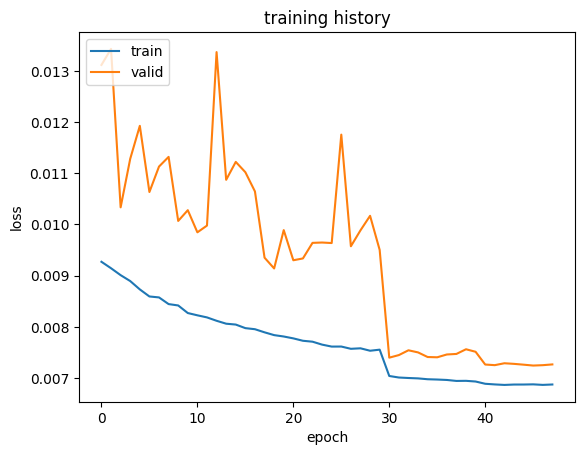

In [34]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

In [35]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

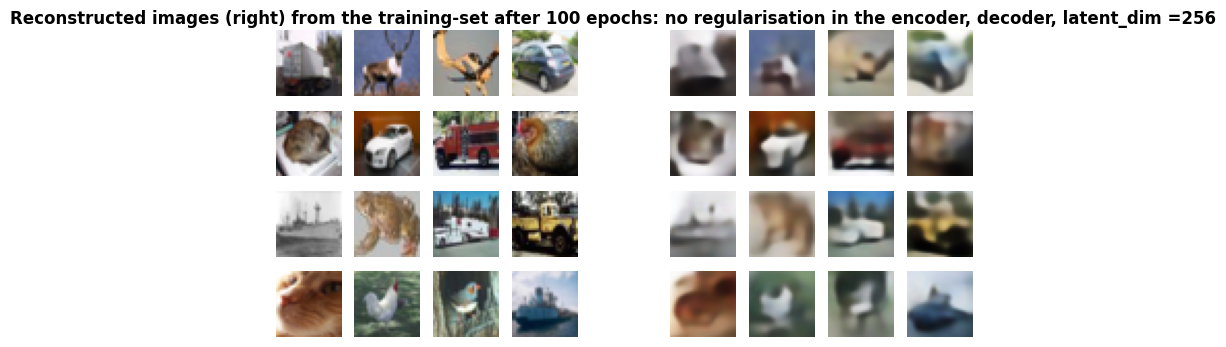

In [36]:
plot_reconstruction(img_train, 'training', 123, 100)

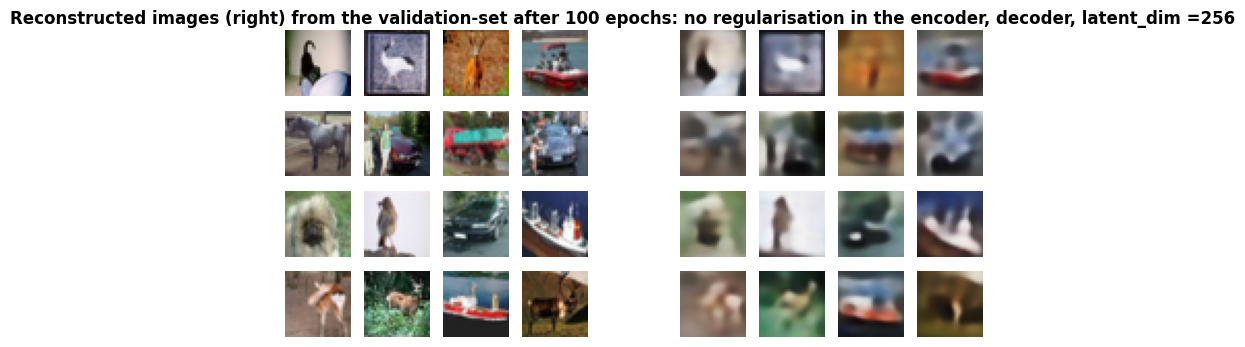

In [37]:
plot_reconstruction(img_valid, 'validation', 123, 100)

Best validation loss perf so far, but not the lowest minima reached.

Naively I'd say it does not make sense to use bridge residual blocks for the one layer deep unit kernel convolutions (and the transverse), so we tried replacing them with plain conv or conv trans layers, but seems like they do make a difference for the better.